# Example: Smoothing Splines

Given $n$ noisy observations 
$$(t_i,y_i), \quad i=1,\dots, n$$
where $y_i = f(t_i) + e_i$ and $e_i\sim \mathcal{N}(0,\sigma)$. We aim to find the underlying function $f$. For the smoothing spline regressions problem the view taken is that $f$ minimizes the following functional
$$
    \text{minimize}\ \mathcal{J}_p(f) \equiv \frac{1}{n}\sum_{i=1}^n(y_i - f(x_i))^2 + \lambda \int_a^b |f^{(p)}(x)|^2\ \mathrm{d}x,
$$
for some $\lambda > 0$. This minimization problem can be viewed as a tradeoff between the interpolation of the data, described by average squared residual and the smoothness, described by the square integral of the $p$th derivative. 

It can be shown that this problem is equivalent with solving the following QP
$$
\text{minimize}\ \frac{1}{n}\|y - (\Sigma c + Hd) \|_2^2 + \lambda c^T\Sigma c
$$
where $H\in\mathbb{R}^{n\times p}$ with elements $H_{i,j} = t_i^{j-1}/((j-1)!)$ and $\Sigma \in\mathbb{R}^{n\times n}$ is a positive definite (kernel) matrix. As shown in (Anders & Chen 2020) $\Sigma$ is rank-structured and have the following form
$$
\Sigma = \text{tril}(UV^T) + \text{triu}(VU^T,1), \quad U,V\in\mathbb{R}^{n\times p}.
$$
As such we say that $\Sigma$ is a $\textit{extended generator representable semiseparable matrix}$ (a EGRSS matrix), giving rise to fast computations. Note that this implicit representation requires only $O(pn)$ storage and in most cases $p << n$ meaning that the implicit representation is a very efficient way of storing the full matrix. Furthermore it is shown in (Andersen & Chen 2020) that the Cholesky factorization (and its inverse) of $\Sigma$ is also implicit represented as
$$
L = \text{tril}(UW^T),\quad U,W\in\mathbb{R}^{n\times p}
$$
$$
L^{-1} = \text{tril}(YW^T) + \text{diag}(c),\quad U,W\in\mathbb{R}^{n\times p},\ c\in\mathbb{R}^n
$$
and can be computed in $O(p^2n) operations. 

Giving noisy observations we will also need to compute on a variant of EGRSS matrices as seen below
$$
K_y = \text{tril}(UV^T) + \text{triu}(VU^T,1) + \text{diag}(d), \quad U,V\in\mathbb{R}^{n\times p},\ d\in\mathbb{R}^n.
$$
We call this a $\textit{extended generator representable quasiseparable matrix}$ (a EGRQS matrix).

In [63]:
using SymEGRSSMatrices, Plots, LinearAlgebra, Optim, Printf, SpecialFunctions
import SymEGRSSMatrices: spline_kernel

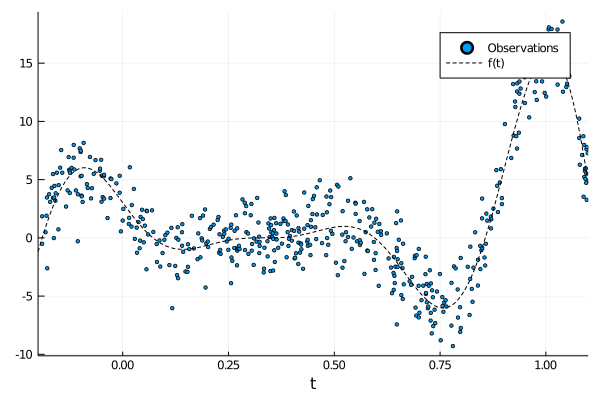

In [64]:
n = 500          # number of samples
σ = 2.0          # noise standard deviation
a,b = -0.2,1.1   # interval [a,b]
δ = b - a

t = a .+ sort(rand(n))*δ;
# FORRESTER ET AL. (2008) FUNCTION
f(t) = (6.0*t .- 2.0).^2 .* sin.(12.0*t .- 4.0)
y = f(t) + σ*randn(length(t),1);

scatter(t, y, ms=2, label="Observations", xlims=(a,b), xlabel="t") 
plot!(a:1.0/n:b, f(a:1.0/n:b), label="f(t)",color=:black, ls=:dash,lw=1)

## Efficiently computing smoothing splines

The optimality coniditions of the previously mentioned QP is equivalent with solving the following system
$$
\begin{bmatrix} \Sigma + n\lambda I & H \\ H^T & 0 \end{bmatrix}
\begin{bmatrix} c \\ d \end{bmatrix}
=
\begin{bmatrix} y \\ 0 \end{bmatrix}.
$$
For simplicity we set $K_y = \Sigma + n\lambda I$. From the first equation we have that
$$
K_yc = y - Hd.
$$
Inserting this into the second equation we have that
$$
H^TK_y^{-1}(y-Hd) = 0 \quad \Rightarrow \quad H^TK_y^{-1}Hd = H^TK_y^{-1}y.
$$
Given that we can compute $K_y = LL^T$ and apply $L^{-1}$ in $O(pn)$ operations we see that we can solve the above systems in linear time w.r.t to $n$.

Note that the above computations i equivalent with fitting a Gaussian process with its kernel matrix equal to $\Sigma$.


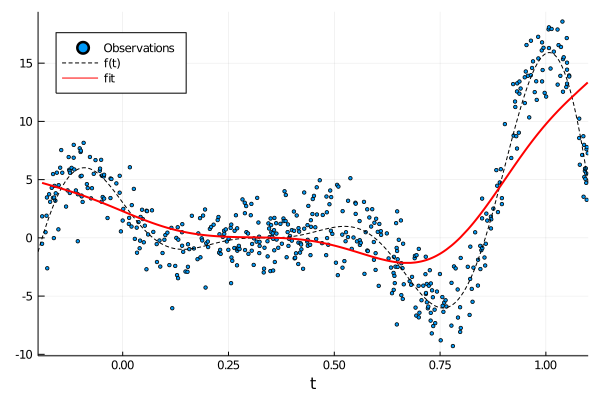

In [65]:
p = 2;
λ = 1e-4;
Ut,Vt = spline_kernel((t' .- a)/(b-a), p);
Σ = SymEGRSSMatrix(Ut*δ^(2p-1),Vt);
H = ones(n,p)
for i = 2:p
  H[:,i] = t.^(p-1)/(factorial(p-1))
end

function smoothing_spline(Σ, H, y, λ)
  n, p = size(H)
  L = cholesky(Σ, n*λ)
  v = L'\(L\y);
  A = (H'*(L'\(L\H)));
  d = A\(H'*v);
  c = L'\(L\(y - H*d));
  log_gml = log(dot(y,c)) + 2.0*logdet(L)/(n-p) + logdet(A)/(n-p);
  return c,d,log_gml
end

c, d, _ = smoothing_spline(Σ, H, y, λ)

scatter(t, y, ms=2, label="Observations", xlims=(a,b), xlabel="t",legend=:topleft) 
plot!(a:1.0/n:b, f(a:1.0/n:b), label="f(t)",color=:black, ls=:dash,lw=1)
plot!(t, Σ*c + H*d, label="fit",color=:red, lw=2)

## Varying the rougness penalty

To see the impact of $\lambda$ as a roughness penalty we plot the solution for different values of $\lambda$.

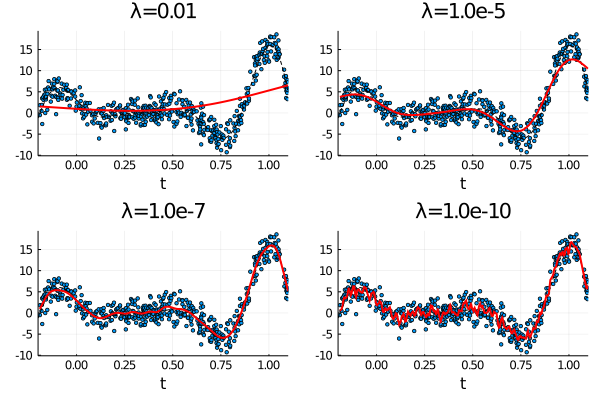

In [66]:
λ = 1e-2;
c, d, _ = smoothing_spline(Σ, H, y, λ);
p1 = scatter(t, y, ms=2, label="Observations", xlims=(a,b), xlabel="t", legend=false);
plot!(a:1.0/n:b, f(a:1.0/n:b), label="f(t)", ls=:dash, color=:black,lw=1)
plot!(t, Σ*c + H*d, label="fit",color=:red, lw=2, title="λ=$λ")

λ = 1e-5;
c, d, _ = smoothing_spline(Σ, H, y, λ);
p2 = scatter(t, y, ms=2, label="Observations", xlims=(a,b), xlabel="t", legend=false);
plot!(a:1.0/n:b, f(a:1.0/n:b), label="f(t)", ls=:dash,color=:black,lw=1)
plot!(t, Σ*c + H*d, label="fit",color=:red,lw=2,title="λ=$λ")

λ = 1e-7;
c, d, _ = smoothing_spline(Σ, H, y, λ);
p3 = scatter(t, y, ms=2, label="Observations", xlims=(a,b), xlabel="t", legend=false);
plot!(a:1.0/n:b, f(a:1.0/n:b), label="f(t)", ls=:dash,color=:black,lw=1)
plot!(t, Σ*c + H*d, label="fit",color=:red,lw=2,title="λ=$λ")


λ = 1e-10;
c, d, _ = smoothing_spline(Σ, H, y, λ);
p4 = scatter(t, y, ms=2, label="Observations", xlims=(a,b), xlabel="t", legend=false);
plot!(a:1.0/n:b, f(a:1.0/n:b), label="f(t)",ls=:dash, color=:black,lw=1)
plot!(t, Σ*c + H*d, label="fit",color=:red,lw=2,title="λ=$λ")

plot(p1,p2,p3,p4)

## Parameter selection
Assuming that the measurement errors $e_i$ are i.i.d Gaussian variables we can estimate the parameters $\sigma_i$ and $\lambda$ using the generalized maximum likelihood function (GML). As stated in (Andersen & Chen 2020) that the GML can be computed as
$$
\log(GML(\lambda)) \propto \log(y^T\hat{c}) + \frac{1}{n-p}\log|K_y| + \frac{1}{n-p}\log|H^TK_y^{-1}H|.
$$
This function can be efficiently valuated as we can efficiently compute the Cholesky factorization of $K_y$ and $H^TK_y^{-1}H$ is a small matrix. From the optimal $\hat{\lambda}$ we can compute the optimal standard deviation as
$$
\hat{\sigma}^2 = n\hat{\lambda}\frac{c^Ty}{n-p}
$$

Results of Optimization Algorithm
 * Algorithm: Golden Section Search
 * Search Interval: [-10.000000, 0.000000]
 * Minimizer: -6.990884e+00
 * Minimum: 7.620522e+00
 * Iterations: 36
 * Convergence: max(|x - x_upper|, |x - x_lower|) <= 2*(1.5e-08*|x|+2.2e-16): true
 * Objective Function Calls: 37


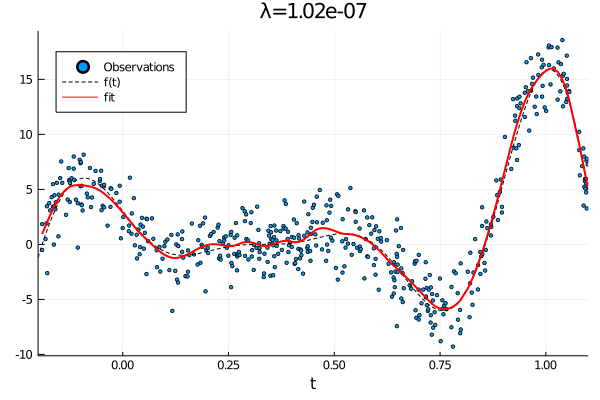

In [67]:
K = SymEGRSSMatrix(Ut*δ^(2p-1),Vt)
function log_gml(v)
  _,_,log_gml = smoothing_spline(K, H, y, 10.0^v);
  return log_gml;
end
res = optimize(log_gml, -10, 0, GoldenSection())
println(res)


λhat = 10.0^res.minimizer;
c, d,_ =  smoothing_spline(K,H,y,λhat)
scatter(t, y, ms=2, label="Observations", xlims=(a,b), xlabel="t", legend=:topleft);
plot!(a:1.0/n:b, f(a:1.0/n:b), label="f(t)", ls=:dash,color=:black,lw=1)
plot!(t, K*c + H*d, label="fit",color=:red,lw=2,title="λ="* @sprintf("%.2e", λhat))

## Confidence intervals
To  compute the Bayesian credible intervals we need to find the diagonal elements of the influence matrix
$$
H(\hat{\lambda}) = I - n\hat{\lambda}(b-a)^{(1-2p)}L^{-T}Q_2Q_2^TL^{-1}.
$$
The standard deviation of the posterior of $y_i$ is then given by
$$
    \sigma_i^2 = \hat{\sigma}^2 e_i^TH(\hat{\lambda})e_i.
$$


In [68]:
L = cholesky(SymEGRSSMatrix(Ut,Vt), n*λhat*δ^(1-2p))
B = L\H;
F = qr(B);
diagH = zeros(n);
for k in 1:n
  ek = zeros(n);
  ek[k] = 1.0;
  v = F.Q'*(L\ek)
  diagH[k] = 1.0 - n*λhat*δ^(1-2p)*norm(v[p+1:end])^2
end


## Visualization of the final solution

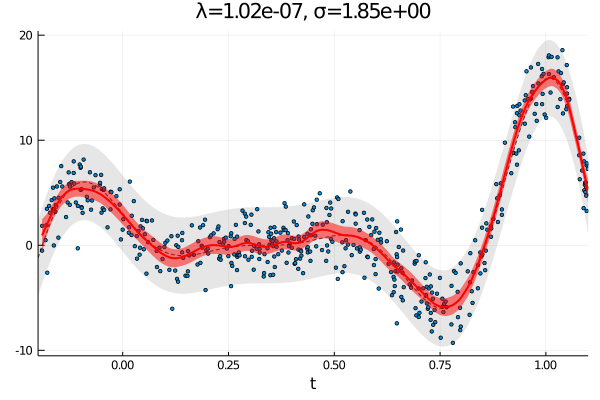

In [69]:
α = 0.05
β = sqrt(2)*erfinv(1-α)
σhat = sqrt(n*λhat*dot(y,c)/(n-p))

scatter(t, y, ms=2, label="Observations", xlims=(a,b), xlabel="t", legend=false);
plot!(a:1.0/n:b, f(a:1.0/n:b), label="f(t)", ls=:dash,color=:black,lw=1, ribbon=β*σhat, alpha=0.8, fillalpha=0.1)
plot!(t, K*c + H*d, label="fit",color=:red,lw=2,title="λ="*@sprintf("%.2e", λhat)*", "*  "σ="* @sprintf("%.2e", σhat), ribbon=β*σhat*sqrt.(diagH), fillalpha=0.5)

## References
1. M. S. Andersen and T. Chen, “Smoothing Splines and Rank Structured Matrices: Revisiting the Spline Kernel,” SIAM Journal on Matrix Analysis and Applications, 2020.